# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [33]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [8]:
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [20]:
n_estimators = 50
base_algo_list = [DecisionTreeRegressor(max_depth=5, random_state=42)]
coeff_list = [0.9]

def gbm_predict(X, base_algorithms_list, coefficients_list):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

y_train_iter = y_train.copy()
base_algo_list[0].fit(X_train, y_train_iter)
y_pred_iter = base_algo_list[0].predict(X_train)

for i in range(1, n_estimators):
    y_train_iter = y_train - y_pred_iter
    
    base_algo_list.append(DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train_iter))
    coeff_list.append(0.9)
    
    y_pred_iter =  np.array(gbm_predict(X_train, base_algo_list, coeff_list))
    print(f"{i} - Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_iter))}")
    
    
    

1 - Train RMSE: 3.179641859438379
2 - Train RMSE: 1.5867023764751826
3 - Train RMSE: 1.3537786436360215
4 - Train RMSE: 1.1149527586144585
5 - Train RMSE: 0.9479595060723494
6 - Train RMSE: 0.8374186389840599
7 - Train RMSE: 0.7351074234388975
8 - Train RMSE: 0.618934234328601
9 - Train RMSE: 0.5460896967039616
10 - Train RMSE: 0.5000348859366555
11 - Train RMSE: 0.4222874406225565
12 - Train RMSE: 0.3493982462642445
13 - Train RMSE: 0.31127806880967757
14 - Train RMSE: 0.2671691164753451
15 - Train RMSE: 0.23993488193993265
16 - Train RMSE: 0.21232013365420574
17 - Train RMSE: 0.18136568655346783
18 - Train RMSE: 0.15851881371998108
19 - Train RMSE: 0.14522908229289314
20 - Train RMSE: 0.12118432125307538
21 - Train RMSE: 0.1127979786066556
22 - Train RMSE: 0.09144122774905195
23 - Train RMSE: 0.08380210256234528
24 - Train RMSE: 0.06837035243983829
25 - Train RMSE: 0.05783406260951677
26 - Train RMSE: 0.051068347843405304
27 - Train RMSE: 0.0459782805333939
28 - Train RMSE: 0.0412048

In [21]:
error1 = mean_squared_error(gbm_predict(X_test, base_algo_list, coeff_list), y_test)

In [22]:
error1

27.293388050902582

In [24]:
with open('ans2.txt', 'w') as f:
    f.write(str(np.sqrt(error1)))

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [26]:
n_estimators = 50
base_algo_list = [DecisionTreeRegressor(max_depth=5, random_state=42)]
coeff_list = [0.9]

y_train_iter = y_train.copy()
base_algo_list[0].fit(X_train, y_train_iter)
y_pred_iter = base_algo_list[0].predict(X_train)

for i in range(1, n_estimators):
    y_train_iter = y_train - y_pred_iter
    
    base_algo_list.append(DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train_iter))
    coeff_list.append(0.9 / (1 + i))
    
    y_pred_iter =  np.array(gbm_predict(X_train, base_algo_list, coeff_list))
    print(f"{i} - Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_iter))}")

1 - Train RMSE: 3.2707316464673495
2 - Train RMSE: 2.5678888013711574
3 - Train RMSE: 2.2280859250705074
4 - Train RMSE: 2.0109966085848017
5 - Train RMSE: 1.8576409180491857
6 - Train RMSE: 1.7517083148683799
7 - Train RMSE: 1.6642832028273573
8 - Train RMSE: 1.60004743263033
9 - Train RMSE: 1.5536548944868813
10 - Train RMSE: 1.5097518416817006
11 - Train RMSE: 1.470851357431395
12 - Train RMSE: 1.4325676377452161
13 - Train RMSE: 1.4051344548833191
14 - Train RMSE: 1.3770188528589085
15 - Train RMSE: 1.3498965765490998
16 - Train RMSE: 1.334391770538966
17 - Train RMSE: 1.3189264546255155
18 - Train RMSE: 1.302364363843851
19 - Train RMSE: 1.2866933623023162
20 - Train RMSE: 1.2725204527941951
21 - Train RMSE: 1.2583322900676919
22 - Train RMSE: 1.2481915858377308
23 - Train RMSE: 1.2384454794464157
24 - Train RMSE: 1.2243271880100977
25 - Train RMSE: 1.2145558738774656
26 - Train RMSE: 1.2069003646843437
27 - Train RMSE: 1.1953465926738798
28 - Train RMSE: 1.189002020559287
29 - Tr

In [28]:
error2 = mean_squared_error(gbm_predict(X_test, base_algo_list, coeff_list), y_test)

with open('ans3.txt', 'w') as f:
    f.write(str(np.sqrt(error1)))

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [31]:
from tqdm import tqdm

In [38]:
n_estimators_list = np.arange(5, 75, 10)


test_scores_estimators = []
train_scores_estimators = []

for n_estimators in tqdm(n_estimators_list):
    base_algo_list = [DecisionTreeRegressor(max_depth=5, random_state=42)]
    coeff_list = [0.9]

    y_train_iter = y_train.copy()
    base_algo_list[0].fit(X_train, y_train_iter)
    y_pred_iter = base_algo_list[0].predict(X_train)

    for i in range(1, n_estimators):
        y_train_iter = y_train - y_pred_iter

        base_algo_list.append(DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train_iter))
        coeff_list.append(0.9 / (1 + i))

        y_pred_iter =  np.array(gbm_predict(X_train, base_algo_list, coeff_list))
        #print(f"{i} - Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_iter))}")
        
    train_error = np.sqrt(mean_squared_error(gbm_predict(X_train, base_algo_list, coeff_list), y_train)) 
    train_scores_estimators.append(train_error)
    test_error = np.sqrt(mean_squared_error(gbm_predict(X_test, base_algo_list, coeff_list), y_test))
    test_scores_estimators.append(test_error)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:28<00:00, 29.84s/it]


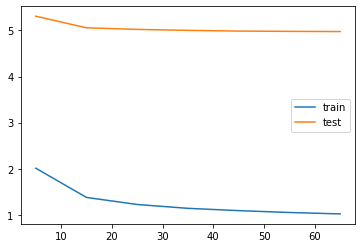

In [39]:
plt.plot(n_estimators_list, train_scores_estimators, label='train')
plt.plot(n_estimators_list, test_scores_estimators, label='test')
plt.legend()

In [40]:
n_estimators = 30
max_depth_list = np.arange(1, 10)

test_scores_depth = []
train_scores_depth = []

for max_depth in tqdm(max_depth_list):
    
    base_algo_list = [DecisionTreeRegressor(max_depth=5, random_state=42)]
    coeff_list = [0.9]

    y_train_iter = y_train.copy()
    base_algo_list[0].fit(X_train, y_train_iter)
    y_pred_iter = base_algo_list[0].predict(X_train)

    for i in range(1, n_estimators):
        y_train_iter = y_train - y_pred_iter

        base_algo_list.append(DecisionTreeRegressor(max_depth=max_depth, random_state=42).fit(X_train, y_train_iter))
        coeff_list.append(0.9 / (1 + i))

        y_pred_iter =  np.array(gbm_predict(X_train, base_algo_list, coeff_list))
        #print(f"{i} - Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_iter))}")
        
    train_error = np.sqrt(mean_squared_error(gbm_predict(X_train, base_algo_list, coeff_list), y_train)) 
    train_scores_depth.append(train_error)
    test_error = np.sqrt(mean_squared_error(gbm_predict(X_test, base_algo_list, coeff_list), y_test))
    test_scores_depth.append(test_error)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:46<00:00, 18.51s/it]


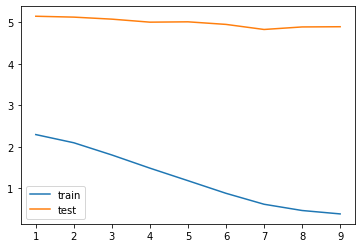

In [42]:
plt.plot(max_depth_list, train_scores_depth, label='train')
plt.plot(max_depth_list, test_scores_depth, label='test')
plt.legend()

In [47]:
ans4 = '2 3'

with open('ans4.txt', 'w') as f:
    f.write(ans4)

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [50]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

ans5 = np.sqrt(mean_squared_error(reg.predict(X_test), y_test))

ans5

5.457311159564055

In [51]:
with open('ans5.txt', 'w') as f:
    f.write(str(ans5))